In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential

In [ ]:
# df_1 = pd.read_csv('dc_part.csv')
# df_2 = pd.read_csv('chenqin5%.csv')
# df_3 = pd.read_csv('miaoqin_partN.csv')
# df_4 = pd.read_csv('yunDataN.csv')
# print(df_1.shape,df_2.shape,df_3.shape,df_4.shape)

In [ ]:
#df.isin([0]).sum()/df.shape[0]

In [2]:
df=pd.read_csv('LWB_Monthly_data.csv',low_memory = False)

In [ ]:
#df.isin([0]).sum()/df.shape[0]

In [ ]:
#df.loc[:,df[df.isin([0]).sum()/df.shape[0]>0.95]]
use=[]
unuse=[]
for col in df.columns:
  if df[col].isin([0]).sum()/df.shape[0]<0.95:
    use.append(col)
  else:
    unuse.append(col)

In [ ]:
data = df.loc[:,use]

# Mergeing the 4 parts of the datasets with the zero-rate less than 95%

In [ ]:
# data_parts=[df_1,df_2,df_3,df_4]
# useful=[] # the column names for each parts that have less than 95% zeros
# for ele in data_parts:
#   useful_sub=[]
#   for col in ele.columns:
#     if ele[col].isin([0]).sum()/ele.shape[0]<0.95:
#       useful_sub.append(col)
#   useful.append(useful_sub)
# useful[2]=useful[2][1:]  # drop unuseful column_name in the 4th parts

In [ ]:
# df_1 = df_1.loc[:,useful[0]]
# df_2 = df_2.loc[:,useful[1]]
# df_3 = df_3.loc[:,useful[2]]
# df_4 = df_4.loc[:,useful[3]]

In [ ]:
#result = pd.concat([df_1,df_2,df_3,df_4], axis=1, sort=False) # combine the dateset

In [ ]:
#result.head()

### Parse 'Dates' and indexs it

In [3]:
df.to_csv('Dataconcate.csv')

In [8]:
Dataset=pd.read_csv('Dataconcate.csv',parse_dates=['_key_occurreddate_month'],index_col=['_key_client_id','_key_occurreddate_month'])

In [ ]:
Dataset.drop(['Unnamed: 0','response_variable'],axis=1).head()

In [10]:
#Dataset.drop(['response_variable'],axis=1).head()

incident_catgry_care_concern_piv  ...  restrictivepractice_isemergency_true_piv
_key_client_id                       _key_occurreddate_month                                    ...                                          
0000D172-EA88-432F-8235-9FAA00D29072 2019-04-01                                              0  ...                                         0
                                     2019-05-01                                              0  ...                                         0
                                     2019-06-01                                              0  ...                                         0
                                     2019-07-01                                              0  ...                                         0
                                     2019-08-01                                              0  ...                                         0

[5 rows x 339 columns]

In [11]:
client_id=list(Dataset.index.get_level_values(0)) # the value of '_key_client_id' index

### Remove the Useless records

In [12]:
from collections import Counter
occurrences = Counter(client_id)

In [13]:
used_id=[]
usedless_id=[]
for key, value in occurrences.items():
  if value==12:  # number can be changed
    used_id.append(key)
  else:
    usedless_id.append(key)

In [14]:
print(f'Useful client:  {len(used_id):d}\nUseless client: {len(usedless_id):d}')

Useful client:  7380
Useless client: 6025


In [15]:
# remove the rows that the record of client is less than 12 month 
Dataset=Dataset.drop(usedless_id,level=0) 
Dataset.shape

(88560, 340)

In [16]:
Dataset.drop(['Incident'],axis=1,inplace=True)

## Perparing Dateset for Modelling

### Spliting to Train and Test Set

In [17]:
split=int(0.9*len(used_id))
train_index=used_id[:split] # the clients who will in trainset
test_index=used_id[split:] # the clients who will in testset

# Train dataset
train=Dataset.loc[train_index]
train_x = train.drop('response_variable',axis=1)
train_y = train.response_variable

# Test Dataset
test=Dataset.loc[test_index]
test_x = test.drop('response_variable',axis=1)
test_y = test.response_variable

print(train.shape,test.shape)

(79704, 339) (8856, 339)


### Normalize the Data

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

train_x = scaler.fit_transform(train_x)

test_x = scaler.transform(test_x)

###Serializing the Dataset

In [19]:
# 4D output
import numpy as np

def create_dataset(X, y, time_steps, window, number):
  xs, ys,channel = [],[],0
  while channel < number: # Ensure all client data have changed to time series type
    xs_sub, ys_sub =[],[]
    for i in range(window - time_steps):
      shifft= window * channel
      v = X[i+shifft:(i + shifft + time_steps)]
      xs_sub.append(v)
      ys_sub.append(y[i + shifft + time_steps])

    channel+=1
    xs.append(xs_sub)
    ys.append(ys_sub)

  return np.array(xs),np.array(ys)

In [20]:
TIME_STEPS = 4
WINDOW = 12 # control client change
NUM_TRAIN = len(train_index)
NUM_TEST = len(test_index)

X_train, y_train = create_dataset(train_x,train_y, TIME_STEPS, WINDOW, NUM_TRAIN)
X_test, y_test = create_dataset(test_x, test_y, TIME_STEPS, WINDOW,NUM_TEST)

In [21]:
# [n_samples, (n_sub_sequence),TIME_STEPS, n_features]
print(X_train.shape, y_train.shape)

(6642, 8, 4, 338) (6642, 8)


In [ ]:
#y_train.counts(1)

## LSTM AutoEncoder

In [22]:
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
''' 4D input [n_samples, n_sub_sequence,TIME_STEPS, n_features]'''
def ConvLSMT_autoencoder(X):
  model = Sequential()
  model.add(layers.TimeDistributed(layers.Conv1D(filters=16, kernel_size=1, activation='relu'), input_shape=(None, X.shape[2], X.shape[3])))
  model.add(layers.TimeDistributed(layers.MaxPooling1D(pool_size=2)))
  model.add(layers.TimeDistributed(layers.Flatten()))
  model.add(layers.LSTM(32, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.RepeatVector(X.shape[2]))
  model.add(layers.LSTM(4, activation='relu', return_sequences=True))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(X.shape[1],activation='sigmoid'))
  return model

In [23]:
model = ConvLSMT_autoencoder(X_train)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 4, 16)       5424      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 2, 16)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 32)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 4, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 4)              5

In [24]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [25]:
history = model.fit(
    X_train,y_train,
    epochs = 500,
    batch_size = 48,
    validation_split = 0.1,
    shuffle = False)

Epoch 1/500
125/125 [==============================] - 2s 14ms/step - loss: 0.6908 - accuracy: 0.4388 - val_loss: 0.6806 - val_accuracy: 0.6316
Epoch 2/500
125/125 [==============================] - 1s 10ms/step - loss: 0.6535 - accuracy: 0.4695 - val_loss: 0.5934 - val_accuracy: 0.8211
Epoch 3/500
125/125 [==============================] - 1s 11ms/step - loss: 0.5732 - accuracy: 0.5093 - val_loss: 0.4991 - val_accuracy: 0.7970
Epoch 4/500
125/125 [==============================] - 1s 10ms/step - loss: 0.4954 - accuracy: 0.4440 - val_loss: 0.3984 - val_accuracy: 0.6707
Epoch 5/500
125/125 [==============================] - 1s 10ms/step - loss: 0.4116 - accuracy: 0.3425 - val_loss: 0.2863 - val_accuracy: 0.2045
Epoch 6/500
125/125 [==============================] - 1s 10ms/step - loss: 0.3356 - accuracy: 0.2749 - val_loss: 0.2312 - val_accuracy: 0.0902
Epoch 7/500
125/125 [==============================] - 1s 11ms/step - loss: 0.2949 - accuracy: 0.2490 - val_loss: 0.2132 - val_accuracy:

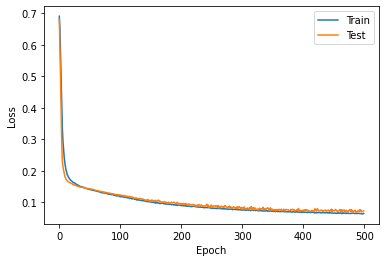

In [26]:
import matplotlib.pyplot as plt
plt.plot(history.epoch, history.history['loss'], label='Train')
plt.plot(history.epoch, history.history['val_loss'], label='Test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Feature improtance
https://machinelearningmastery.com/calculate-feature-importance-with-python/

Permutation feature importance is a technique for calculating **relative** importance scores that is independent of the model used.

In [47]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot

In [ ]:
results = permutation_importance(model, X_train, y_train, scoring='neg_mean_squared_error')

In [ ]:
#pip install eli5

In [ ]:
#import eli5
#from eli5.sklearn import PermutationImportance

In [ ]:
#perm = PermutationImportance(model, random_state=1,scoring="accuracy").fit(X_train,y_train,)
#eli5.show_weights(perm, feature_names = X_train.columns.tolist())

## Find the threshold for dividing positive samples and neigative samples

In [27]:
predict = model.predict(X_test)
#predict.shape

In [ ]:
#predict[1]

In [ ]:
#predict[0]

In [28]:
month=['May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
Client = used_id[-y_test.shape[0]:]

preidct_df = pd.DataFrame(predict,columns=month,index=Client,)
True_df=pd.DataFrame(y_test,columns=month,index=Client)

In [ ]:
preidct_df.describe()

In [ ]:
preidct_df.head()

In [ ]:
True_df.head()

## Build a dataframe which contains two columns: Predited_value and True_Value for modelling

In [29]:
# Combine dataframe to a single column
len=preidct_df.shape[0]
name_all=[] # predicted values
value_all=[] # months
true_all=[]
for elem in month:
  value_all+=(list(preidct_df[str(elem)]))
  true_all += (list(True_df[str(elem)]))
  name_all += [elem]*len

In [30]:
# build the client column
client=[]
for i in range(preidct_df.shape[1]):
  client+=Client

In [31]:
# Build the datafame
dataset=pd.DataFrame(zip(value_all,name_all,true_all),columns=['Predict','Month','Label'])
dataset['Client_id']=client
dataset.set_index(['Month','Client_id'],inplace=True)
dataset.head()

Predict  Label
Month Client_id                                                
May   DB10AF3E-0F92-E011-A5C6-B6A03279A8B3  3.209441e-36      0
      DB1CE471-B20F-434C-B4D4-9F6D00D10976  1.339487e-29      0
      F771E77B-341D-4672-B6AD-A43500AB411B  8.857987e-24      0
      F77DFB42-B83B-47FD-BBA9-A88D00E983C1  1.588169e-38      0
      E9D0885E-57E7-4EE6-A384-A61200D8ABF1  1.705792e-33      0

## Spliting the predicted value to Test and Train sets for finding the threshold

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
rate=0.2
train, test = train_test_split(dataset, test_size=rate, random_state=5)

In [34]:
'''splitting the dataset to X and Y'''
# X
train_xth = train.Predict
test_xth = test.Predict

# Y
train_yth = train.Label
test_yth = test.Label

print('The sizes for training dataset and test dataset:\n',train_xth.shape,test_xth.shape)

The sizes for training dataset and test dataset:
 (4723,) (1181,)


### Plotting the Loss

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


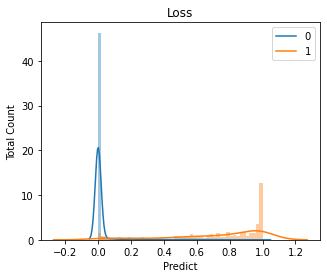

In [45]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5, 4))
for i in [0,1]:
  sns.distplot(train_xth.loc[train.Label==i], bins=50,kde=True)
ax.set_ylabel('Total Count')
ax.set_title('Loss')
ax.legend('01')
plt.savefig('lossPlot.png')

### Finding the best threshold

In [36]:
# from the above plot we can choose the threshold to be 0.2 or greater
'''Generate the list for thresholds'''
threshold = []
num = 4000
start=0.2
for i in range(num):
  val= start+0.0001*i
  threshold.append(val)


In [37]:
# generate the list of f1_scores 
from sklearn.metrics import f1_score
f1_scores=[]
for thres in threshold:
  Predited_label = []
  for elem in test_xth:
    if elem < thres:
      Predited_label.append(0)
    else:
      Predited_label.append(1)
  f1s=f1_score(test_yth, Predited_label, zero_division=0)
  f1_scores.append(f1s)

In [38]:
# get the corrodinate of the largest f1_score
y=max(f1_scores)
max_index = f1_scores.index(max(f1_scores))
x=threshold[max_index]

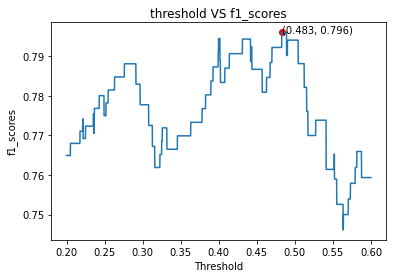

In [39]:
plt.plot(threshold,f1_scores)
plt.title('threshold VS f1_scores')
plt.scatter(x, y, c='red')
plt.xlabel('Threshold')
plt.ylabel('f1_scores')
plt.text(x, y, '({:5.3f}, {:5.3f})'.format(x, y))
plt.savefig('threshold_choose.png')
plt.show()

In [40]:
print(f'The best f1_scores is{y: 5.4f} for threshold is{x: 5.4f}.')

The best f1_scores is 0.7961 for threshold is 0.4827.


### Show the performance of the model

In [41]:
# label the prediction with the choosen threshold
predited_label=[]
incident_index=[]# incident list
for elem in test_xth:
  if elem < x:
    predited_label.append(0)
  else:
    predited_label.append(1)
    indx = test_xth.loc[(test_xth.loc[:]==elem),:].index.values.tolist()
    incident_index+=indx

In [42]:
from sklearn.metrics import classification_report

report = classification_report(test_yth, predited_label,labels=[1,0])
print(report)

              precision    recall  f1-score   support

           1       0.81      0.78      0.80       105
           0       0.98      0.98      0.98      1076

    accuracy                           0.96      1181
   macro avg       0.90      0.88      0.89      1181
weighted avg       0.96      0.96      0.96      1181



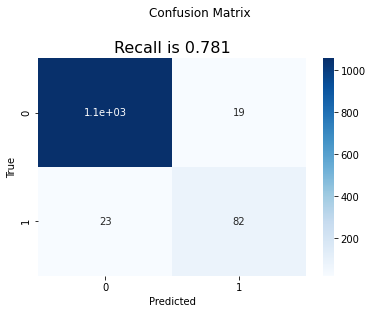

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(test_yth, predited_label)
recal = cm[1][1]/sum(cm[1])

sns.heatmap(cm, annot=True,cmap='Blues')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title(f'Recall is {recal:0.3f}',y=1.05, fontsize=16)
plt.suptitle('Confusion Matrix',y=1.06)

plt.savefig('Confusion_matrix.png')
plt.show()

The best result is when epcho is 500, threshold is 0.258, and f1_score is 0.771  and recall is 0.81. (drop out rate 0.2)

## The clients who should pay attention to.

In [46]:
print('The risky clients in each month:')
df=pd.DataFrame(incident_index,columns=['Month', 'Client_id'])
df.sort_values(by=['Month'])

The risky clients in each month:


,Month,Client_id
24,Aug,F9820D32-26C4-4CE9-959C-A60400B41C28
39,Aug,E714D2C2-0D31-40CC-BA86-A462014699B8
3,Aug,F83448CE-AD2E-412C-B7EB-A8D000D9E91F
6,Aug,EEA15CAA-1BCC-4B77-858D-6411976138F9
92,Aug,F3FB6D6E-F935-4D13-8482-A2EA00AACFA0
...,...,...
36,Sep,FC3769A9-E075-E011-97F0-B6A03279A8B3
16,Sep,FA381413-9F46-4093-8E71-192D86BDB089
48,Sep,EF1E6180-A15F-4A21-BE0D-A86400FD634E
12,Sep,DF97393F-9427-409D-B221-A44800E853C7
